In [2]:
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.odr import ODR, Model, RealData

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)

from main_code.utils.constants import *
from main_code.utils.CosmoFunc import *
from main_code.utils.functions import bin_data, bin_data_median, bin_data_error_weighting

# 1. $\bar{r}$ as dependent variable

## 1.1. Sanity check: ensure $a, b, c$ are constant

In [4]:
df = pd.read_csv("./rmean_fixed/fp_fit.csv", index_col=0)

df["c"] = df["rmean"] - df["a"] * df["smean"] - df["b"] * df["imean"]

df

,a,b,rmean,smean,imean,s1,s2,s3,c
6dFGS,1.448729,-0.894661,0.183428,2.267443,3.212890,0.043593,0.288428,0.143943,-0.227037
SDSS,1.448729,-0.894661,0.160247,2.234876,3.186064,0.044883,0.272526,0.164057,-0.227037
LAMOST,1.448729,-0.894661,-0.034789,2.159482,3.281979,0.048764,0.276377,0.167504,-0.227037


In [28]:
df = pd.read_csv("./smean_fixed/fp_fit.csv", index_col=0)

df["c"] = df["rmean"] - df["a"] * df["smean"] - df["b"] * df["imean"]

df

,a,b,rmean,smean,imean,s1,s2,s3,c
6dFGS,1.448729,-0.894661,0.183430,2.267444,3.212890,0.043593,0.288437,0.143942,-0.227037
SDSS,1.448729,-0.894661,0.160253,2.234900,3.186097,0.044883,0.272536,0.164034,-0.227037
LAMOST,1.448729,-0.894661,-0.034818,2.159488,3.282021,0.048765,0.276414,0.167495,-0.227037


In [29]:
df = pd.read_csv("./imean_fixed/fp_fit.csv", index_col=0)

df["c"] = df["rmean"] - df["a"] * df["smean"] - df["b"] * df["imean"]

df

,a,b,rmean,smean,imean,s1,s2,s3,c
6dFGS,1.448729,-0.894661,0.183414,2.267438,3.212897,0.043594,0.288436,0.143946,-0.227037
SDSS,1.448729,-0.894661,0.160258,2.234888,3.186072,0.044883,0.272530,0.164046,-0.227037
LAMOST,1.448729,-0.894661,-0.034812,2.159493,3.282022,0.048764,0.276410,0.167497,-0.227037


## 1.2. Histogram of logdists

6dFGS
Mean logdist:  -0.0002913389844846381 | Median logdist:  0.007259740506077949

SDSS
Mean logdist:  -0.019187865570233505 | Median logdist:  -0.0207286239930738

LAMOST
Mean logdist:  -0.025275064714515127 | Median logdist:  -0.023927752023680797

Combined sample
Mean logdist:  -0.01102415446946236 | Median logdist:  -0.0073337450029095



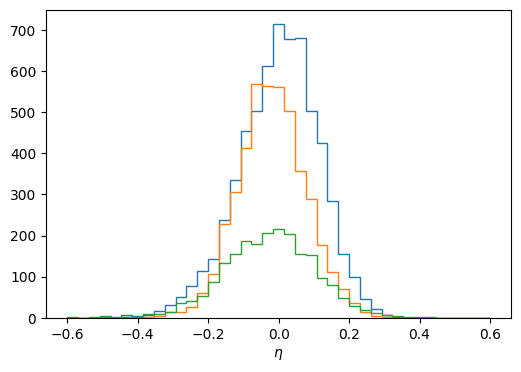

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))
bins_ = np.linspace(-0.6, 0.6, 40)

df_combined = pd.DataFrame()
for survey in SURVEY_LIST:
    df = pd.read_csv(f"./rmean_fixed/{survey.lower()}.csv")

    print(survey)
    print("Mean logdist: ", df["logdist_rmean_fixed"].mean(), "| Median logdist: ", df["logdist_rmean_fixed"].median())
    print()

    ax.hist(df["logdist_rmean_fixed"], bins=bins_, histtype="step")

    df_combined = pd.concat([df_combined, df])

print("Combined sample")
print("Mean logdist: ", df_combined["logdist_rmean_fixed"].mean(), "| Median logdist: ", df_combined["logdist_rmean_fixed"].median())
print()

ax.set_xlabel(r"$\eta$")

plt.show()

## 1.3. North-south consistency check

Rejected comparison: 0


/var/folders/50/_r7c0z0x3bl4zx6npn1b1x480000gn/T/ipykernel_1283/3145210457.py:34: RuntimeWarning: invalid value encountered in sqrt
  xerr = np.sqrt(df[f"logdist_err_south"].to_numpy()**2 - sigma_r_int**2)


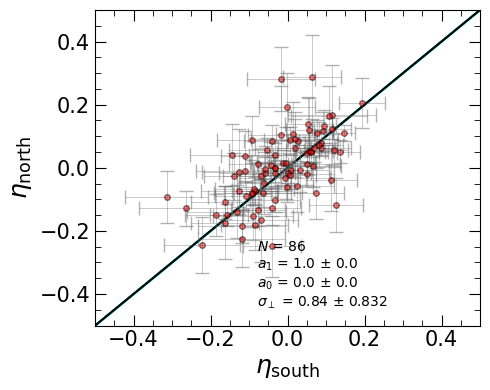

In [7]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

fig, axs = plt.subplots(figsize=(5, 4))
ax_titles = ['without PV model']

sigma_r_int = 0.044 * np.sqrt(1 + 1.448729**2 +	0.894661**2)

for i, datapath in enumerate(['./rmean_fixed/']):
    df_north = pd.DataFrame()
    for survey in ['sdss', 'lamost']:
        df_temp = pd.read_csv(datapath + survey + '.csv')[['tmass', 'ra', 'dec', f'logdist_rmean_fixed', f'logdist_err_rmean_fixed']]
        df_temp = df_temp.rename({f'logdist_rmean_fixed': 'logdist', f'logdist_err_rmean_fixed': 'logdist_err'}, axis=1)
        df_north = pd.concat([df_north, df_temp])

    df_south = pd.read_csv(datapath + '6dfgs.csv')[['tmass', 'logdist_rmean_fixed', 'logdist_err_rmean_fixed']]
    df_south = df_south.rename({'logdist_rmean_fixed': 'logdist', 'logdist_err_rmean_fixed': 'logdist_err'}, axis=1)

    df = df_north.merge(df_south, on='tmass', how='inner', suffixes=('_north', '_south'))
    df["chisq"] = np.absolute(df[f"logdist_north"] - df[f"logdist_south"]) / np.sqrt(df[f"logdist_err_north"]**2 + df[f"logdist_err_south"]**2)

    df_rejects = df[df["chisq"] > 3.0]
    print(f"Rejected comparison: {len(df_rejects)}")
    df = df[df["chisq"] <= 3.]

    ndata = len(df)
    x = df[f"logdist_south"].to_numpy()
    xerr = np.sqrt(df[f"logdist_err_south"].to_numpy()**2 - sigma_r_int**2)
    y = df[f"logdist_north"].to_numpy()
    yerr = np.sqrt(df[f"logdist_err_north"].to_numpy()**2 - sigma_r_int**2)
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax = fig.axes[i]
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects[f"logdist_south"], df_rejects[f"logdist_north"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlabel(r'$\eta_\mathrm{south}$', fontsize=18)
    ax.set_ylabel(r'$\eta_\mathrm{north}$', fontsize=18)
    # ax.set_title(ax_titles[i], fontsize=14)

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.42, 0.27, text_, transform=ax.transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='left')

fig.tight_layout()
# fig.savefig('./north_vs_south_individual_fp.pdf', bbox_inches='tight', dpi=300)

## 1.4. Self-consistency check

Rejected comparison in ('6dFGS', 'SDSS'): 0
Rejected comparison in ('SDSS', 'LAMOST'): 17
Rejected comparison in ('6dFGS', 'LAMOST'): 7


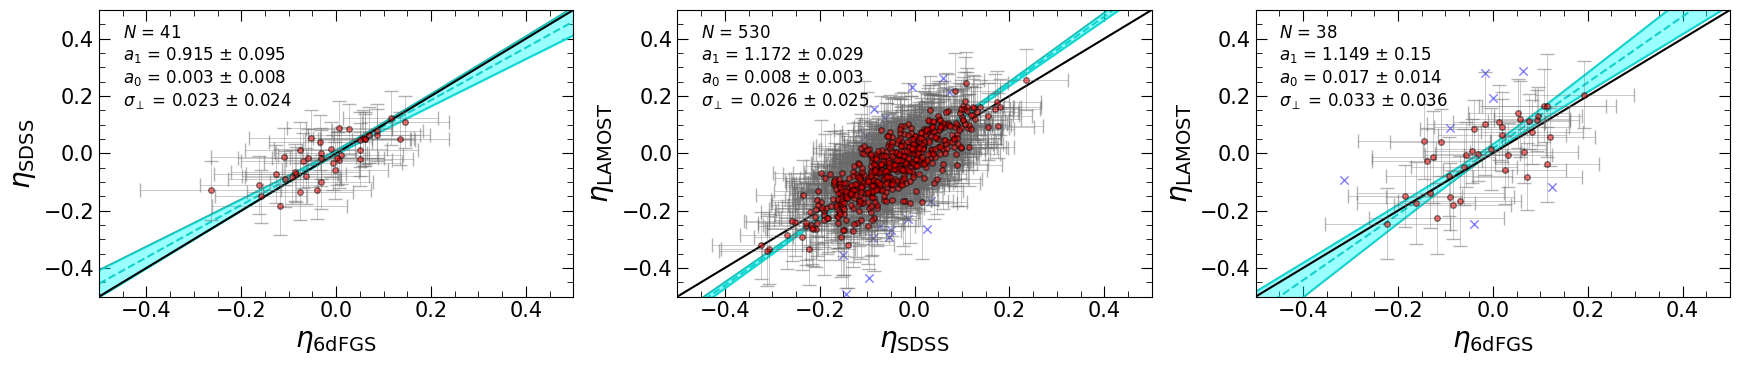

In [27]:
fp_fit = "ALL_COMBINED"

def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

figure_size = 5
fig, ax = plt.subplots(ncols=3, figsize=(figure_size * 3.5, figure_size * 0.75))

ALL_COMBOS = [('6dFGS', 'SDSS'), ('SDSS', 'LAMOST'), ('6dFGS', 'LAMOST')]
for i, ax in enumerate(fig.axes):
    # Load data
    combo = ALL_COMBOS[i]
    survey1 = combo[0]
    survey2 = combo[1]

    df1 = pd.read_csv(f"./rmean_fixed/{survey1.lower()}.csv")
    df2 = pd.read_csv(f"./rmean_fixed/{survey2.lower()}.csv")
    df = df1.merge(df2, on='tmass', how='inner')
    df["chisq"] = np.absolute(df["logdist_rmean_fixed_x"] - df["logdist_rmean_fixed_y"]) / np.sqrt(df["logdist_err_rmean_fixed_x"]**2 + df["logdist_err_rmean_fixed_y"]**2)
    df_rejects = df[df["chisq"] > 1.0]
    print(f"Rejected comparison in {combo}: {len(df_rejects)}")
    df = df[df["chisq"] <= 1.]

    ndata = len(df)
    x = df[f"logdist_rmean_fixed_x"].to_numpy()
    xerr = df[f"logdist_err_rmean_fixed_x"].to_numpy()
    y = df[f"logdist_rmean_fixed_y"].to_numpy()
    yerr = df[f"logdist_err_rmean_fixed_y"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects["logdist_rmean_fixed_x"], df_rejects["logdist_rmean_fixed_y"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r"$\eta_\mathrm{survey1}$".replace("survey1", survey1), fontsize=20)
    ax.set_ylabel(r"$\eta_\mathrm{survey2}$".replace("survey2", survey2), fontsize=20)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.05, 0.95, text_, transform=ax.transAxes, fontsize=12, 
         verticalalignment='top', horizontalalignment='left')
    

fig.tight_layout()
# fig.savefig('../img/final_plot/fig_11a_internal_consistency_checks_combined_fp.pdf', bbox_inches='tight', dpi=300)

## 1.5. PV vs redshift

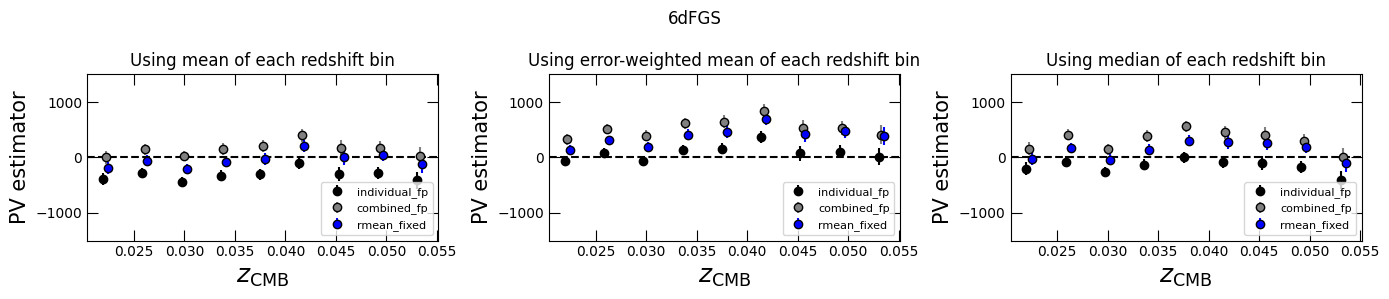

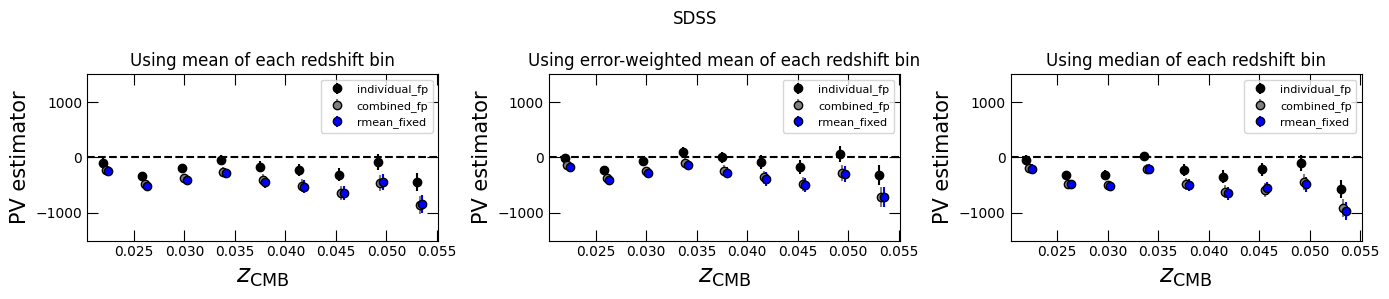

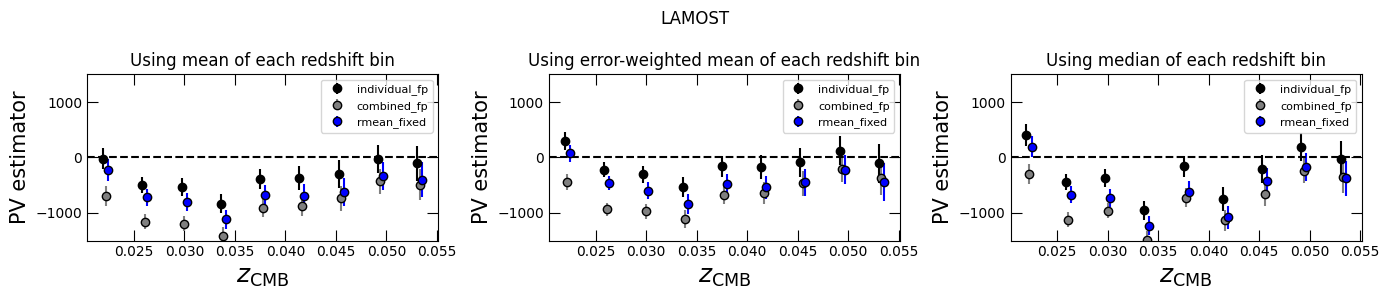

In [6]:
for i, survey in enumerate(SURVEY_LIST):
    fig, axs = plt.subplots(ncols=3, figsize=(14, 3))
    fig.suptitle(survey)

    # Load old data
    df_old = pd.read_csv(f"../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")
    df_old["logdist_individual_fp"] = df_old[f"logdist_{survey.lower()}"]
    df_old["logdist_err_individual_fp"] = df_old[f"logdist_err_{survey.lower()}"]
    df_old["logdist_combined_fp"] = df_old["logdist_all_combined"]
    df_old["logdist_err_combined_fp"] = df_old["logdist_err_all_combined"]
    df_old = df_old[[col for col in df_old.columns if col in ["tmass", "logdist_individual_fp", "logdist_err_individual_fp", "logdist_combined_fp", "logdist_err_combined_fp"]]]

    # Load new data
    df_new = pd.read_csv(f"./rmean_fixed/{survey.lower()}.csv")

    # Cross-match
    df = df_old.merge(df_new, on="tmass")

    epsilon = 0.75
    z_col = "z_dist_est"

    colors = ["black", "grey", "blue", "red", "green"]

    # Functions to average the data
    avg_functions = [bin_data, bin_data_error_weighting, bin_data_median]
    avg_func_labels = ["mean", "error-weighted mean", "median"]

    for j, func in enumerate(avg_functions):
        ax = fig.axes[j]
        for k, method in enumerate(["individual_fp", "combined_fp", "rmean_fixed"]):
            df["pv"] = LightSpeed * df[z_col] * df[f"logdist_{method}"] * np.log(10) / (1 + epsilon * df[z_col])
            df["pv_err"] = LightSpeed * df[z_col] * df[f"logdist_err_{method}"] * np.log(10) / (1 + epsilon * df[z_col])

            # Get error-weighted average in bins
            x = df[z_col].to_numpy()
            y = df[f"pv"].to_numpy()
            yerr = df[f"pv_err"].to_numpy()

            # Bin the data in redshift
            x_bin, y_ew_bin, y_ew_bin_err, y_ew_bin_stderr = func(x, y, yerr, 0.02, 0.055, 10)

            # Plot
            ax.errorbar(x_bin + k * 0.00025, y_ew_bin, yerr=y_ew_bin_stderr, fmt="o", mec='k', mfc=colors[k], ecolor=colors[k], alpha=1.0, label=method)

        ax.set_title(avg_func_labels[j])
        ax.axhline(y=0, c='k', ls='--')
        ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
        ax.set_ylabel("PV estimator", fontsize=15)
        ax.set_title(f"Using {avg_func_labels[j]} of each redshift bin")

        ax.set_ylim(-1500, 1500)
        ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
        ax.tick_params(axis='both', which='both', labelsize=10, direction="in")
        ax.tick_params(axis='both', which='major', length=8)
        ax.tick_params(axis='both', which='minor', length=4)

        if i != 0:
            ax.legend(loc="upper right", fontsize=8)
        else:
            ax.legend(loc="lower right", fontsize=8)

    fig.tight_layout()
    # fig.savefig(f"./mean.png", bbox_inches='tight', dpi=300)

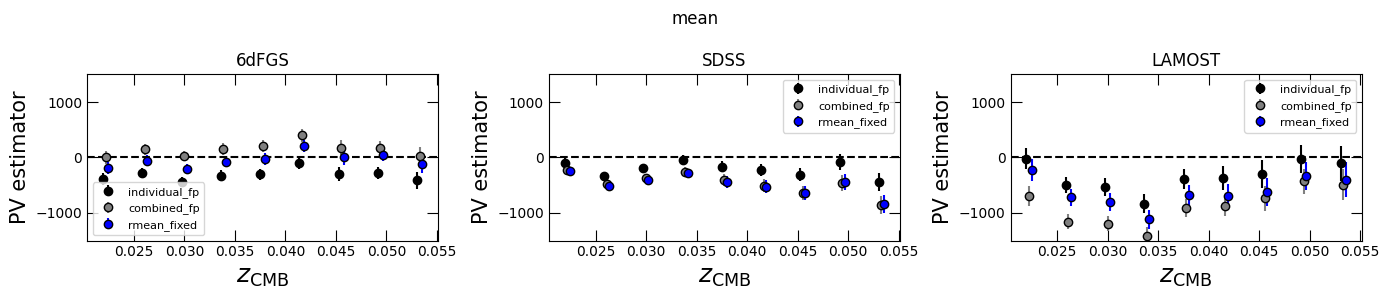

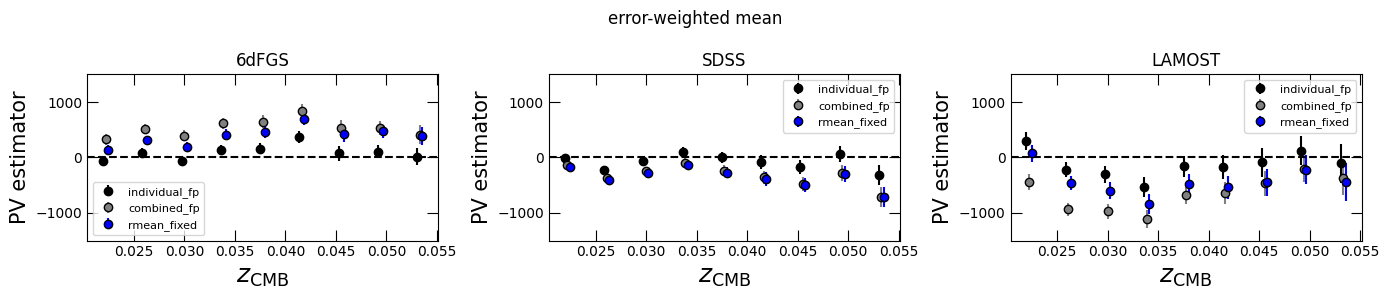

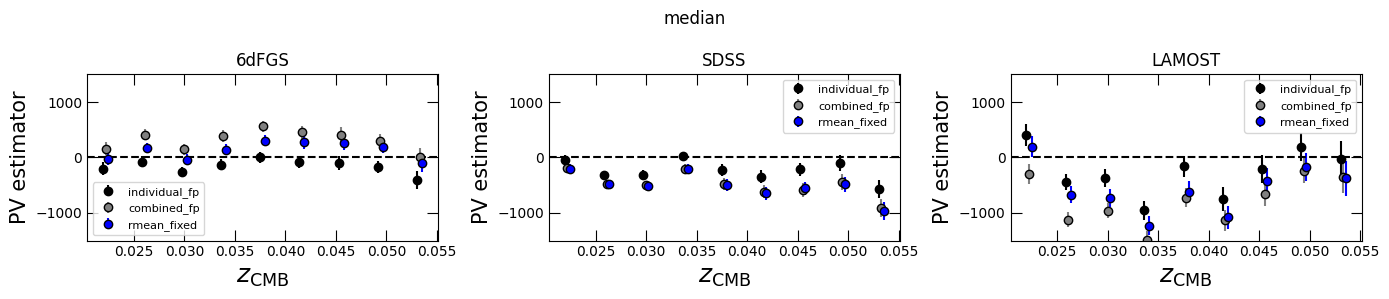

In [19]:
# Functions to average the data
avg_functions = [bin_data, bin_data_error_weighting, bin_data_median]
avg_func_labels = ["mean", "error-weighted mean", "median"]

for i, func in enumerate(avg_functions):
    fig, axs = plt.subplots(ncols=3, figsize=(14, 3))
    fig.suptitle(avg_func_labels[i])

    for j, survey in enumerate(SURVEY_LIST):
        ax = fig.axes[j]

        # Load old data
        df_old = pd.read_csv(f"../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")
        df_old["logdist_individual_fp"] = df_old[f"logdist_{survey.lower()}"]
        df_old["logdist_err_individual_fp"] = df_old[f"logdist_err_{survey.lower()}"]
        df_old["logdist_combined_fp"] = df_old["logdist_all_combined"]
        df_old["logdist_err_combined_fp"] = df_old["logdist_err_all_combined"]
        df_old = df_old[[col for col in df_old.columns if col in ["tmass", "logdist_individual_fp", "logdist_err_individual_fp", "logdist_combined_fp", "logdist_err_combined_fp"]]]

        # Load new data
        df_new = pd.read_csv(f"./rmean_fixed/{survey.lower()}.csv")

        # Cross-match
        df = df_old.merge(df_new, on="tmass")

        epsilon = 0.75
        z_col = "z_dist_est"

        colors = ["black", "grey", "blue", "red", "green"]

        for k, method in enumerate(["individual_fp", "combined_fp", "rmean_fixed"]):
            df["pv"] = LightSpeed * df[z_col] * df[f"logdist_{method}"] * np.log(10) / (1 + epsilon * df[z_col])
            df["pv_err"] = LightSpeed * df[z_col] * df[f"logdist_err_{method}"] * np.log(10) / (1 + epsilon * df[z_col])

            # Get error-weighted average in bins
            x = df[z_col].to_numpy()
            y = df[f"pv"].to_numpy()
            yerr = df[f"pv_err"].to_numpy()

            # Bin the data in redshift
            x_bin, y_ew_bin, y_ew_bin_err, y_ew_bin_stderr = func(x, y, yerr, 0.02, 0.055, 10)

            # Plot
            ax.errorbar(x_bin + k * 0.00025, y_ew_bin, yerr=y_ew_bin_stderr, fmt="o", mec='k', mfc=colors[k], ecolor=colors[k], alpha=1.0, label=method)

        ax.set_title(survey)
        ax.axhline(y=0, c='k', ls='--')
        ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
        ax.set_ylabel("PV estimator", fontsize=15)

        ax.set_ylim(-1500, 1500)
        ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
        ax.tick_params(axis='both', which='both', labelsize=10, direction="in")
        ax.tick_params(axis='both', which='major', length=8)
        ax.tick_params(axis='both', which='minor', length=4)

        if j == 0:
            ax.legend(loc="lower left", fontsize=8)
        else:
            ax.legend(loc="upper right", fontsize=8)

    fig.tight_layout()
    # fig.savefig(f"./mean.png", bbox_inches='tight', dpi=300)

# 2. $\bar{s}$ as dependent variable

## 2.1. Sanity check: ensure $a, b, c$ are constant

In [23]:
df = pd.read_csv("./smean_fixed/fp_fit.csv", index_col=0)

df["c"] = df["rmean"] - df["a"] * df["smean"] - df["b"] * df["imean"]

df

,a,b,rmean,smean,imean,s1,s2,s3,c
6dFGS,1.448729,-0.894661,0.183430,2.267444,3.212890,0.043593,0.288437,0.143942,-0.227037
SDSS,1.448729,-0.894661,0.160253,2.234900,3.186097,0.044883,0.272536,0.164034,-0.227037
LAMOST,1.448729,-0.894661,-0.034818,2.159488,3.282021,0.048765,0.276414,0.167495,-0.227037


## 2.2. Histogram of logdists

6dFGS
Mean logdist:  -0.00029173849529075355 | Median logdist:  0.007260658821975

SDSS
Mean logdist:  -0.019188514493267243 | Median logdist:  -0.020729651641727

LAMOST
Mean logdist:  -0.025276356879457482 | Median logdist:  -0.023933798064834248

Combined sample
Mean logdist:  -0.011024789904712605 | Median logdist:  -0.0073329189387235



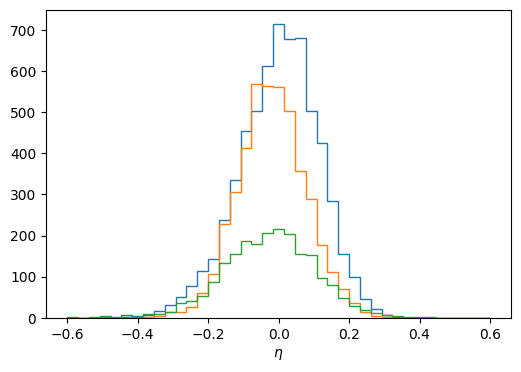

In [26]:
fig, ax = plt.subplots(figsize=(6, 4))
bins_ = np.linspace(-0.6, 0.6, 40)

df_combined = pd.DataFrame()
for survey in SURVEY_LIST:
    df = pd.read_csv(f"./smean_fixed/{survey.lower()}.csv")

    print(survey)
    print("Mean logdist: ", df["logdist_smean_fixed"].mean(), "| Median logdist: ", df["logdist_smean_fixed"].median())
    print()

    ax.hist(df["logdist_smean_fixed"], bins=bins_, histtype="step")

    df_combined = pd.concat([df_combined, df])

print("Combined sample")
print("Mean logdist: ", df_combined["logdist_smean_fixed"].mean(), "| Median logdist: ", df_combined["logdist_smean_fixed"].median())
print()

ax.set_xlabel(r"$\eta$")

plt.show()

## 2.3. North-south consistency check

Rejected comparison: 0


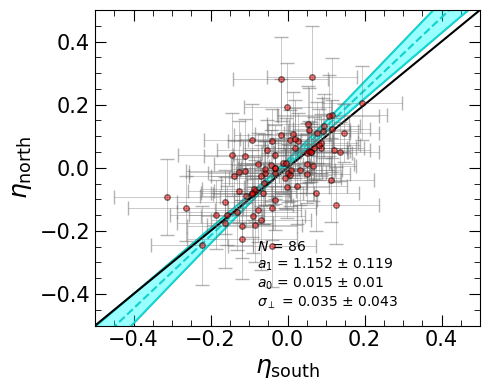

In [27]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

fig, axs = plt.subplots(figsize=(5, 4))
ax_titles = ['without PV model']

for i, datapath in enumerate(['./smean_fixed/']):
    df_north = pd.DataFrame()
    for survey in ['sdss', 'lamost']:
        df_temp = pd.read_csv(datapath + survey + '.csv')[['tmass', 'ra', 'dec', f'logdist_smean_fixed', f'logdist_err_smean_fixed']]
        df_temp = df_temp.rename({f'logdist_smean_fixed': 'logdist', f'logdist_err_smean_fixed': 'logdist_err'}, axis=1)
        df_north = pd.concat([df_north, df_temp])

    df_south = pd.read_csv(datapath + '6dfgs.csv')[['tmass', 'logdist_smean_fixed', 'logdist_err_smean_fixed']]
    df_south = df_south.rename({'logdist_smean_fixed': 'logdist', 'logdist_err_smean_fixed': 'logdist_err'}, axis=1)

    df = df_north.merge(df_south, on='tmass', how='inner', suffixes=('_north', '_south'))
    df["chisq"] = np.absolute(df[f"logdist_north"] - df[f"logdist_south"]) / np.sqrt(df[f"logdist_err_north"]**2 + df[f"logdist_err_south"]**2)

    df_rejects = df[df["chisq"] > 999.0]
    print(f"Rejected comparison: {len(df_rejects)}")
    df = df[df["chisq"] <= 999.]

    ndata = len(df)
    x = df[f"logdist_south"].to_numpy()
    xerr = df[f"logdist_err_south"].to_numpy()
    y = df[f"logdist_north"].to_numpy()
    yerr = df[f"logdist_err_north"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax = fig.axes[i]
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects[f"logdist_south"], df_rejects[f"logdist_north"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlabel(r'$\eta_\mathrm{south}$', fontsize=18)
    ax.set_ylabel(r'$\eta_\mathrm{north}$', fontsize=18)
    # ax.set_title(ax_titles[i], fontsize=14)

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.42, 0.27, text_, transform=ax.transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='left')

fig.tight_layout()
# fig.savefig('./north_vs_south_individual_fp.pdf', bbox_inches='tight', dpi=300)